In [1]:
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
from psmiles import PolymerSmiles as PS
from torch.utils.data import DataLoader, Dataset, random_split
from rdkit import Chem
from rdkit.Chem import Draw
from PIL import Image
from scipy.sparse import csr_matrix, lil_matrix
import atomInSmiles
from collections import Counter
from IPython.display import clear_output, display
import ipywidgets as widgets
from tqdm.notebook import tqdm
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatter, LogLocator, LogFormatterMathtext
from typing import List, Dict, Tuple
from torch.distributions import Normal, kl_divergence
import torch.nn.functional as F
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device=torch.device('cpu')
print(device)
# os.chdir("C:\\Users\\user\\test.venv")
# print(os.getcwd())
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline

log_transformer = FunctionTransformer(np.log1p, validate=True)
log_minmax_pipeline = Pipeline(steps=[
    ('log', log_transformer),
    ('minmax', MinMaxScaler())
])

cuda


23


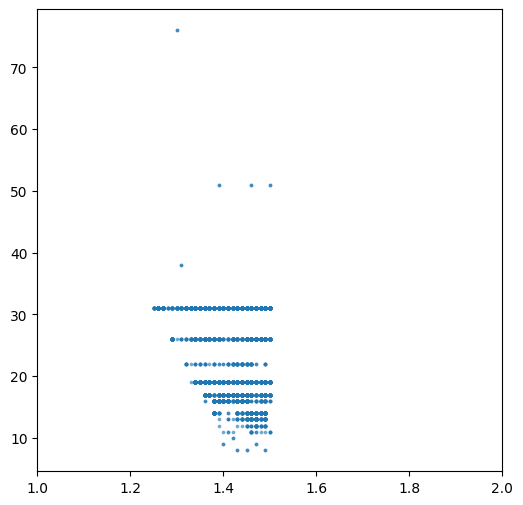

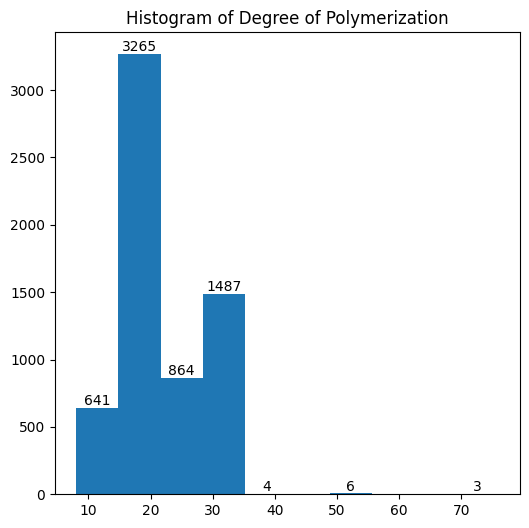

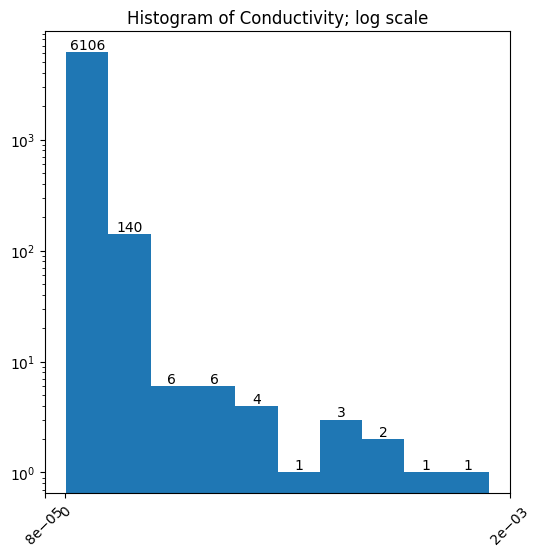

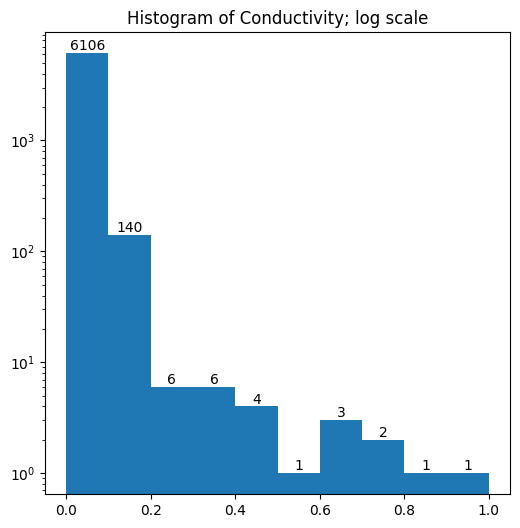

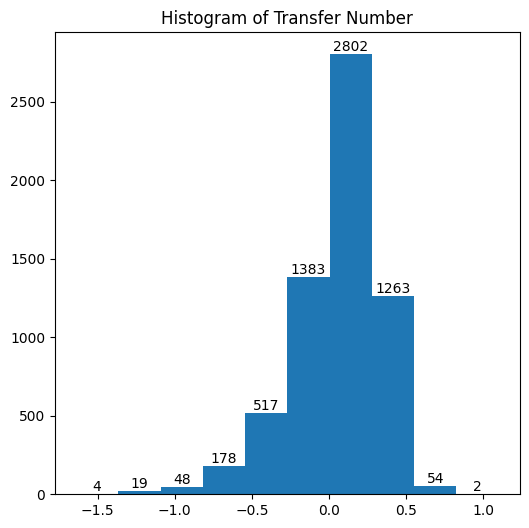

(array([   4.,    2.,    2.,    7.,   35.,   89.,   74.,  218.,  458.,
         874., 1331., 1500., 1163.,  267.,  217.,   25.,    0.,    0.,
           2.,    2.]),
 array([ 5.  ,  6.85,  8.7 , 10.55, 12.4 , 14.25, 16.1 , 17.95, 19.8 ,
        21.65, 23.5 , 25.35, 27.2 , 29.05, 30.9 , 32.75, 34.6 , 36.45,
        38.3 , 40.15, 42.  ]),
 <BarContainer object of 20 artists>)

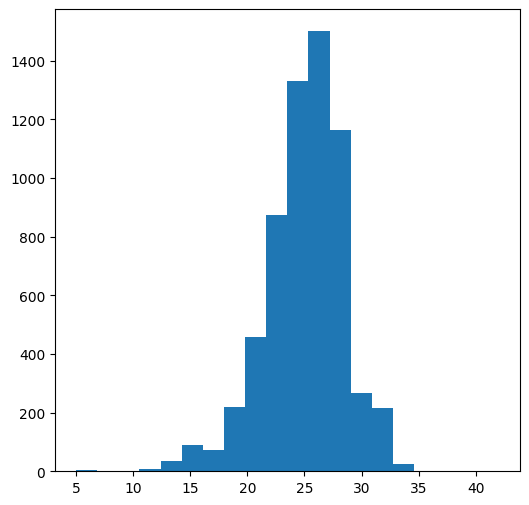

In [2]:
test_dd = pd.read_csv("simulation-trajectory-aggregate.csv")
molal = test_dd.iloc[:, 2:3].values
dp = test_dd.iloc[:, 4:5].values
con = test_dd.iloc[:, 6:7].values
tnn = test_dd.iloc[:, 10:11].values
smiles = test_dd.iloc[:, 1:2].values.squeeze()
print(len(smiles[0]))
#DP scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(molal, dp, s=3, alpha=0.5)
plt.xlim([1.0, 2.0])

#DP histogram
plt.figure(figsize=(6,6))
counts, bins, patches = plt.hist(dp, bins=10)
plt.title("Histogram of Degree of Polymerization")

for count, x in zip(counts, bins):
    if count == 0:
        continue
    plt.text(x + (bins[1] - bins[0]) / 2, count,    # x 좌표는 막대의 가운데
             str(int(count)),                      # 정수로 변환한 count
             ha='center', va='bottom')             # 가운데 정렬
plt.show()

#Li+ Conductivity hitogram
plt.figure(figsize=(6,6))
counts, bins, patches = plt.hist(con)
plt.yscale('log')
plt.xscale('symlog')
ax = plt.gca()
ax.xaxis.set_major_formatter(LogFormatter())
plt.xticks(rotation=45)  # 라벨 회전
plt.title("Histogram of Conductivity; log scale")
for count, x in zip(counts, bins):
    plt.text(x + (bins[1] - bins[0]) / 2, count,    # x 좌표는 막대의 가운데
             str(int(count)),                      # 정수로 변환한 count
             ha='center', va='bottom')             # 가운데 정렬
plt.show()

con_log = log_minmax_pipeline.fit_transform(con.reshape(-1, 1))
#Li+ Conductivity hitogram
plt.figure(figsize=(6,6))
counts, bins, patches = plt.hist(con_log)
plt.yscale('log')
plt.title("Histogram of Conductivity; log scale")
for count, x in zip(counts, bins):
    plt.text(x + (bins[1] - bins[0]) / 2, count,    # x 좌표는 막대의 가운데
             str(int(count)),                      # 정수로 변환한 count
             ha='center', va='bottom')             # 가운데 정렬
plt.show()


#Li+ Transfer Number histogram
plt.figure(figsize=(6,6))
counts, bins, patches = plt.hist(tnn, bins=10)
for count, x in zip(counts, bins):
    if count == 0:
        continue
    plt.text(x + (bins[1] - bins[0]) / 2, count,    # x 좌표는 막대의 가운데
             str(int(count)),                      # 정수로 변환한 count
             ha='center', va='bottom')             # 가운데 정렬
plt.title("Histogram of Transfer Number")
plt.show()

#SMILES Length Histogram
plt.figure(figsize=(6,6))
plt.hist([len(smiles[i]) for i in range(6270)], bins=20)

In [3]:
mm_scaler = MinMaxScaler()
class load_data(Dataset):
    def __init__(self, path):
        #csv 읽기
        self.raw = pd.read_csv(path)

        #SMILES
        self.SMILES = self.raw.iloc[:, 1:2].values
        self.SMILES = np.squeeze(self.SMILES)

        #Li-ion Conductivity
        self.conductivity = self.raw.iloc[:, 6:7].values
        self.conductivity = log_minmax_pipeline.fit_transform(self.conductivity.reshape(-1, 1))

        #Degree of Polymerization
        self.DP = self.raw.iloc[:, 4:5].values
        self.DP = mm_scaler.fit_transform(self.DP.reshape(-1, 1))

        #Transfer Number
        self.tn = self.raw.iloc[:, 10:11].values
        self.tn1 = self.tn
        self.tn = mm_scaler.fit_transform(self.tn.reshape(-1, 1))

        #Labels
        self.label = self.raw.iloc[:, 11:12].values

        self.properties = np.concat((self.conductivity, self.DP, self.tn), axis=-1)

        #PSMILES 변환
        psmiles = []
        for smiles in self.SMILES:
            ps = PS(smiles)
            ps.canonicalize
            psmiles.append(ps.psmiles)

        #Atom-In-SMILES Encoding
        ais_encoding = []
        for smiles in psmiles:
            ais_encoding.append(atomInSmiles.encode(smiles))
        

        #Atom-In-SMILES Tokenization (Encoder)
        ais_tokens = []
        for smiles in ais_encoding:
            ais_tokens.append(atomInSmiles.smiles_tokenizer("[CLS] [SOS] " + smiles +" [EOS]"))

        max_len = len(max(ais_encoding, key=len)) + 1
        self.max_len = max_len
        print("max sequence length : ", max_len)

        #vocab 구성
        corpus = []
        for frags in ais_tokens:
            corpus.extend(frags)
        corpus.append("[PAD]")
        token_count = Counter(corpus)
        vocab = { token:i for i, (token, count) in enumerate(sorted(token_count.items(), key=lambda x: x[1], reverse=True))}
        vocab_size = len(vocab)
        
        self.vocab = vocab

        num_data = len(ais_tokens)
        print(vocab)

        ais_tokens_enc = ais_tokens
        ais_tokens_enc = [[tok for tok in tokens if tok not in ['[SOS]', '[EOS]']] for tokens in ais_tokens_enc]

        ais_tokens_dec_input = ais_tokens
        ais_tokens_dec_input = [[tok for tok in tokens if tok not in ['[CLS]','[EOS]']] for tokens in ais_tokens_dec_input]

        ais_tokens_dec_output = ais_tokens
        ais_tokens_dec_output = [[tok for tok in tokens if tok not in ['[CLS]','[SOS]']] for tokens in ais_tokens_dec_output]

        #Tokens to number (encoder)
        ais_token_num_enc = torch.full((num_data, max_len),166, dtype=torch.long)
        i=0
        for tokens in ais_tokens_enc:
            for length in range((len(tokens))):
                ais_token_num_enc[i, length] = vocab[tokens[length]]
            i += 1

        #Tokens to number (Decoder Input)
        ais_token_num_dec_input = torch.full((num_data, max_len),166, dtype=torch.long)
        i=0
        for tokens in ais_tokens_dec_input:
            for length in range((len(tokens))):
                ais_token_num_dec_input[i, length] = vocab[tokens[length]]
            i += 1

        #Tokens to number (Decoder Output)
        ais_token_num_dec_output = torch.full((num_data, max_len),166, dtype=torch.long)
        i=0
        for tokens in ais_tokens_dec_output:
            for length in range((len(tokens))):
                ais_token_num_dec_output[i, length] = vocab[tokens[length]]
            i += 1

        self.SMILES_enc = ais_token_num_enc
        self.SMILES_dec_input = ais_token_num_dec_input
        self.SMILES_dec_output = ais_token_num_dec_output

        vocab_size, num_data
        print("vocab size : ", vocab_size,"\nnumber of data : ",num_data)
        self.num_data = num_data
        
        self.vocab = vocab
        self.vocab_size = vocab_size


        print(self.SMILES_enc.shape)
        self.properties = torch.tensor(self.properties, dtype=torch.float).unsqueeze(-1)
        print(self.properties.shape)

        self.test_data = self.SMILES_enc[50]

        print("PSMILES : ", psmiles[50])
        print("After AIS encoding : ", ais_encoding[50])
        print("After AIS Tokenization : ", ais_tokens_enc[50])
        print("After to number : ", ais_token_num_enc[50])
        print(len(ais_token_num_enc[50]))
        
        self.label = torch.tensor(self.label, dtype=torch.uint8)
    
    def __getitem__(self, i):
        return self.SMILES_enc[i], self.SMILES_dec_input[i], self.SMILES_dec_output[i], self.properties[i], self.label[i]
    
    def __len__(self):
        return self.SMILES_enc.shape[0]
    
    def vocab_len(self):
        return self.vocab_size

In [4]:

Polymers = "simulation-trajectory-aggregate_aligned.csv"
dataset = load_data(Polymers)

generator = torch.Generator()
train_dataset, val_dataset = random_split(dataset, [0.75, 0.25], generator=generator)

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, drop_last=False)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False, drop_last=False)

max sequence length :  265
{'(': 0, ')': 1, '=': 2, '[O;!R;C]': 3, '[CH3;!R;C]': 4, '[CH2;!R;CN]': 5, '[CH2;!R;CC]': 6, '[CH2;!R;CO]': 7, '[*;!R;C]': 8, '[CLS]': 9, '[SOS]': 10, '[EOS]': 11, '[O;!R;CC]': 12, '[NH;!R;CC]': 13, '[*;!R;O]': 14, '[O;!R;*C]': 15, '[C;!R;*OO]': 16, '[CH;!R;CCO]': 17, '[CH;!R;CCN]': 18, '[C;!R;CNO]': 19, '[N;!R;CCC]': 20, '[C;!R;*NO]': 21, '[NH;!R;*C]': 22, '[*;!R;N]': 23, '[CH3;!R;N]': 24, '[CH;!R;CCC]': 25, '[C;!R;CCCO]': 26, '[CH;!R;CC]': 27, '[F;!R;C]': 28, '[CH2;!R;C]': 29, '[C;!R;COO]': 30, '[CH3;!R;O]': 31, '[C;!R;CCCN]': 32, '#': 33, '[C;!R;CCCC]': 34, '[CH2;!R;CS]': 35, '[C;!R;CC]': 36, '[OH;!R;C]': 37, '[S;!R;CC]': 38, '[N;!R;C]': 39, '[C;!R;CN]': 40, '[CH;!R;C]': 41, '[C;!R;CCC]': 42, '[NH2;!R;C]': 43, '[CH;!R;CFF]': 44, '[O;!R;S]': 45, '[O;!R;CN]': 46, '[CH;!R;CCS]': 47, '[CH2;!R;CF]': 48, '[CH3;!R;S]': 49, '[C;!R;CCO]': 50, '[NH;!R;CO]': 51, '[CH2;!R;*C]': 52, '[C;!R;NNO]': 53, '[C;!R;CFFF]': 54, '[C;!R;CCFF]': 55, '[C;!R;NOO]': 56, '[C;!R;OOO]':

In [5]:
def reverse_one_hot_encoding(one_hot_tensor, vocab):
    # 인덱스 → 토큰 매핑 생성
    index_to_token = {idx: token for token, idx in vocab.items()}

    # 복원된 토큰 시퀀스를 저장할 리스트
    original_tokens_list = []

    # GPU 텐서면 CPU로
    if one_hot_tensor.is_cuda:
        one_hot_tensor = one_hot_tensor.cpu()

    # one-hot → argmax (인덱스 시퀀스)
    try:
        _ = one_hot_tensor.shape[1]
        one_hot_tensor = F.softmax(one_hot_tensor, dim=-1)
        one_hot_tensor = torch.argmax(one_hot_tensor, dim=-1)
    except:
        pass  # 이미 1D 라면 그대로 둠

    # “값이 166인” 위치만 추출
    idx_166 = torch.nonzero(one_hot_tensor == 166, as_tuple=True)[0]

    idx_11 = torch.nonzero(one_hot_tensor == 11, as_tuple=True)[0]

    # 만약 166 토큰이 하나도 없으면 전체 길이 사용
    end_pos = idx_166[0].item() if len(idx_166) > 0 else one_hot_tensor.size(0)
    end_pos = idx_11[0].item() if len(idx_11) > 0 else end_pos

    # 0부터 end_pos 직전까지 토큰 복원
    for i in range(end_pos):
        token_idx = one_hot_tensor[i].item()
        original_tokens_list.append(index_to_token.get(token_idx, "<UNK>"))

    return original_tokens_list
print(dataset.test_data)
test = reverse_one_hot_encoding(dataset.test_data, dataset.vocab)
print(test)
print(atomInSmiles.decode(' '.join(test)))
#print(dataset.vocab)

def logsumexp(x):
    c = x.max()
    return c + np.log(np.sum(np.exp(x - c)))


tensor([  9,  14,  15,   7,   6,  47,   0,   4,   1,  38,  35,   7,  12,   7,
          7,  12,  16,   0,   8,   1,   2,   3, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 1

In [6]:
import math
#from torch_pca import PCA
from torch.nn import TransformerDecoder, TransformerDecoderLayer, TransformerEncoder, TransformerEncoderLayer

class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-12):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, unbiased=False, keepdim=True)

        out = (x - mean) / torch.sqrt(var + self.eps)
        out = self.gamma * out + self.beta
        return out

class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x : torch.Tensor) -> torch.Tensor:
        pos_embedding =  self.pe[:, :x.size(1), :]
        pos_embedding = torch.repeat_interleave(pos_embedding, x.shape[0], dim=0)
        x =  torch.cat([x, pos_embedding], dim=2)
        return self.dropout(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model=64, nhead=4):
        super(MultiHeadAttention, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, batch_first=True)

    def forward(self, query, key, value, attn_mask=None) -> torch.Tensor:
        attn_output, _ = self.multihead_attn(query, key, value, attn_mask=attn_mask)
        return attn_output

class MY_TF_encoder(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1,
                 activation="relu", layer_norm_eps=1e-5, batch_first=False):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout,
                                               batch_first=batch_first)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.linear3 = nn.Linear(d_model, dim_feedforward)
        self.linear4 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model, eps=layer_norm_eps)
        self.norm2 = nn.LayerNorm(d_model, eps=layer_norm_eps)
        self.norm3 = nn.LayerNorm(d_model, eps=layer_norm_eps)
        self.norm4 = nn.LayerNorm(d_model, eps=layer_norm_eps)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        self.dropout4 = nn.Dropout(dropout)
        
        self.crossattn = MultiHeadAttention(d_model=d_model, nhead=nhead)

        # Activation function
        if activation == "relu":
            self.activation = F.relu
        elif activation == "gelu":
            self.activation = F.gelu
        else:
            raise ValueError("Unsupported activation: {}".format(activation))

    def forward(self, src, prop, src_mask=None, src_key_padding_mask=None) -> torch.Tensor:
        # Self-attention
        attn_output, _ = self.self_attn(src, src, src,
                                        attn_mask=src_mask,
                                        key_padding_mask=src_key_padding_mask)
        src = src + self.dropout1(attn_output)
        src = self.norm1(src)
        # Feedforward
        ff = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(ff)
        src = self.norm2(src)

        # Self-attention (properties)
        attn_output, _ = self.self_attn(prop, prop, prop,
                                        attn_mask=src_mask,
                                        key_padding_mask=src_key_padding_mask)
        prop = prop + self.dropout1(attn_output)
        prop = self.norm1(prop)
        # Feedforward (properties)
        ff = self.linear2(self.dropout(self.activation(self.linear1(prop))))
        prop = prop + self.dropout2(ff)
        prop = self.norm2(prop)

        # Cross-Attention
        crossattn = self.crossattn(src, prop, prop)
        src = src + self.dropout3(crossattn)
        src = self.norm3(src)

        # Feedfoward
        ff = self.linear4(self.dropout(self.activation(self.linear3(src))))
        src = src + self.dropout4(ff)
        src = self.norm4(src)
        return src

In [7]:
class TFEncoder(nn.Module):
    def __init__(self, d_model=256, n_heads=4, d_ff=64, enc_seq_len=5000, dropout=0.2):
        super().__init__()
        self.normLayer = LayerNorm(d_model=d_model)
        
        self.encoderLayer = TransformerEncoderLayer(batch_first=True,
                                               d_model=d_model,
                                               nhead=n_heads,
                                               dim_feedforward=d_ff,
                                               dropout=dropout,
                                               activation="gelu")
        self.encoder = TransformerEncoder(encoder_layer=self.encoderLayer, num_layers=2, norm=self.normLayer)
        self.input_embedding_smiles = nn.Embedding(dataset.vocab_size, d_model // 2)
        self.pos_encoding = PositionalEncoding(d_model // 2, dropout, max_len=enc_seq_len)

        self.conv = nn.Conv1d(3, 265, 1)


    def forward(self, smiles_enc:torch.Tensor, properties:torch.Tensor) -> torch.Tensor:
        smiles_enc = self.input_embedding_smiles(smiles_enc) # [B, seq_len, d_model // 2]
        enc_input_0 = self.pos_encoding(torch.cat((smiles_enc, properties),dim=1)) # [B, seq_len, 256]

        encoded_0 = self.encoder(enc_input_0)
        return encoded_0

class TFDecoder(nn.Module):
    def __init__(self, d_model=256, n_heads=4, d_ff=64, enc_seq_len=5000, dropout=0.2, latent_dim=64):
        super().__init__()
        self.normLayer = LayerNorm(d_model=d_model)

        self.decoderLayer = TransformerDecoderLayer(batch_first=True,
                                               d_model=d_model,
                                               nhead=n_heads,
                                               dim_feedforward=d_ff,
                                               dropout=dropout,
                                               activation="gelu")
        self.decoder = TransformerDecoder(decoder_layer=self.decoderLayer,
                                          num_layers=2,
                                          norm=self.normLayer)

        self.input_embedding_smiles = nn.Embedding(dataset.vocab_size, d_model // 2)
        self.pos_encoding = PositionalEncoding(d_model // 2, dropout, max_len=enc_seq_len)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
    
    def forward(self, dec_input : torch.Tensor, latent : torch.Tensor) -> torch.Tensor:
        dec_input = self.input_embedding_smiles(dec_input)
        dec_input_0 = self.pos_encoding(dec_input)
        x_mask = self.generate_square_subsequent_mask(dec_input.shape[1]).to(device)
        memory_mask = self.generate_square_subsequent_mask(latent.shape[1]).to(device)

        decoded = self.decoder(dec_input_0, latent, tgt_mask=x_mask, memory_mask = memory_mask)
        return decoded


In [8]:
class CVAE(nn.Module):
    def __init__(self, d_model=256, latent_dim=64, prop_dim=1, n_comp=3):
        super().__init__()
        self.latent_dim = latent_dim
        # posterior encoder
        self.encoder = TFEncoder(d_model=d_model, n_heads=4, d_ff=64, enc_seq_len=5000)
        self.conv = nn.Conv1d(in_channels=268, out_channels=265, kernel_size=1)
        self.to_means  = nn.Linear(d_model, latent_dim)
        self.to_logvar = nn.Linear(d_model, latent_dim)
        # mixture prior net
        self.prior_net = MixturePrior(y_dim=3, latent_dim=latent_dim, n_comp=n_comp, hidden_dim=64)
        # decoder & remainder
        self.decoder = TFDecoder(d_model=d_model, n_heads=4, d_ff=64, enc_seq_len=5000, latent_dim=latent_dim)
        self.predict = nn.Linear(d_model, dataset.vocab_size)
        # property head (optional)
        self.prop_pred = nn.Linear(latent_dim, prop_dim)
        self.input_embedding = nn.Sequential(
            nn.Linear(1, d_model // 8),
            nn.GELU(),
            nn.Linear(d_model // 8, d_model // 4),
            nn.GELU(),
            nn.Linear(d_model // 4, d_model // 2),
            nn.GELU()
        )

        self.z_classif = nn.Linear(latent_dim*265, 3)

        self.to_memory = nn.Linear(latent_dim, d_model)
        self.to_pred = nn.Conv1d(265, 3, 1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std


    def forward(self, smiles_enc, smiles_dec_input, properties):
        """
        Args:
            smiles_enc : SMILES 인코더 입력 [B, L, 1]
            smiles_dec_input : SMILES 디코더 입력 [B, L, 1]
            properties : 고분자 특성 값(조건 y에 해당) [B, 3, 1]

        Returns:
            logits : 디코더 출력 [B, L, 1]
            mu_q : Psosterior mu [B, L, D]
            logvar_q : Posterior logvar [B, L, D]
            pi_p : Prior pi [B, L, K]
            mu_p : Prior mu [B, L, K, H]
            logvar_p : Prior logvar [B, L, K, H]
            z_q : Posterior z [B, L, D]
            prop_pred : Posterior z 를 특성 값 예측하도록 강제 > Collapse 방지  [B, L, 1]
            encoded : 생성시 prior 만을 쓰기 위해 Loss 계산용 출력 [B, L, 256]
            z_classifier : [B, 3, 1]
        """
        # 1) posterior encoding
        properties_e = self.input_embedding(properties) # [B, 3, d_model]
        encoded      = self.encoder(smiles_enc, properties_e)  # [B, 265, d_model]
        encoded      = self.conv(encoded)
        # summary token (CLS or mean)
        mu_q         = self.to_means(encoded) # [B, L, latent_dim]
        logvar_q     = torch.clamp(self.to_logvar(encoded), min=-3., max=3.) # [B, L, latent_dim]
        z_q          = self.reparameterize(mu_q, logvar_q)  # [B, L, latent_dim]

        # 2) mixture prior
        pi_logits, pi_p, mu_p, logvar_p = self.prior_net(properties)  # [B,L,K], [B,L,K,D], [B,L,K,D]

        # 3) decode
        dec_output   = self.decoder(smiles_dec_input, self.to_memory(z_q))     # [B, L, d_model]
        logits:torch.Tensor       = self.predict(dec_output)                        # [B, L, V]

        # 4) property prediction head (auxiliary)
        prop_pred    = self.to_pred(z_q)                # [B, prop_dim, D]
        prop_pred    = self.prop_pred(prop_pred)        # [B, prop_dim,1]

        # 5) z classifier
        z_classifier = self.z_classif(z_q.view(-1, 265*self.latent_dim))

        return logits, mu_q, logvar_q, pi_p, mu_p, logvar_p, z_q, prop_pred, encoded, pi_logits, z_classifier

class MixturePrior(nn.Module):
    def __init__(self, y_dim=3, latent_dim=64, n_comp=5, hidden_dim=64, seq_len=265):
        super().__init__()
        self.seq_len    = seq_len
        self.n_comp     = n_comp
        self.latent_dim = latent_dim

        # 1) 속성 y → 길이-L 시퀀스로 단순 복제
        # 2) position-wise shared MLP
        self.shared = nn.Sequential(
            nn.Linear(y_dim, hidden_dim), nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim), nn.GELU()
        )
        # 3) mixture heads
        self.fc_pi     = nn.Linear(hidden_dim, n_comp)
        self.fc_mu     = nn.Linear(hidden_dim, n_comp * latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, n_comp * latent_dim)

    def forward(self, y: torch.Tensor):
        """
        y: [B, 3, 1]  ⇒ 먼저 [B, 3] 로 줄이고
        → [B, L, 3] 로 브로드캐스트
        """
        B = y.size(0)
        # 1) squeeze trailing dim, broadcast to seq_len
        y2 = y.squeeze(-1)                             # [B, 3]

        y_seq = y2.unsqueeze(1).expand(-1, self.seq_len, -1)  # [B, L, 3]

        # 2) shared MLP (per position)
        h = self.shared(y_seq)                         # [B, L, H]

        # 3) mixture parameters
        logits = self.fc_pi(h)                         # [B, L, K]
        pi     = F.softmax(logits, dim=-1)             # [B, L, K]

        mu_all     = self.fc_mu(h) \
                         .view(B, self.seq_len, self.n_comp, self.latent_dim)    # [B, L, K, D]
        logvar_all = self.fc_logvar(h) \
                         .view(B, self.seq_len, self.n_comp, self.latent_dim)    # [B, L, K, D]

        return logits, pi, mu_all, logvar_all




In [9]:
from pytorch_metric_learning.losses import SupConLoss

class ConditionalVAELoss(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        max_beta: float = 1.0,
        anneal_steps: int = 1000,
        free_bits: float = 0.0,
        capacity: float = 0.0,
        gamma: float = 1.0,
        prop_loss_w: float = 1.0,
        supcon_w: float = 1.0,
        sep_w: float = 1.0
    ):
        super().__init__()
        self.vocab_size   = vocab_size
        self.max_beta     = max_beta
        self.anneal_steps = anneal_steps
        self.free_bits    = free_bits
        self.capacity     = capacity
        self.gamma        = gamma
        self.prop_w       = prop_loss_w

        # supervised contrastive loss on z
        self.supcon       = SupConLoss(temperature=0.1)
        self.supcon_w     = supcon_w

        # initial weight for separation CE
        self.sep_w        = sep_w

    def kld_mixture(self, q_mu, q_logvar, pi, mu_p, logvar_p, n_samples: int = 3):
        B, L, D = q_mu.shape
        K       = pi.shape[2]

        q_std = torch.exp(0.5 * q_logvar)
        eps   = torch.randn(n_samples, B, L, D, device=q_mu.device)
        z_samp = q_mu.unsqueeze(0) + q_std.unsqueeze(0) * eps   # [S,B,L,D]

        q_dist    = Normal(q_mu, q_std)
        log_qz    = q_dist.log_prob(z_samp).sum(-1)              # [S,B,L]

        mu_exp    = mu_p.unsqueeze(0)                           # [1,B,L,K,D]
        std_exp   = torch.exp(0.5*logvar_p).unsqueeze(0)         # [1,B,L,K,D]
        z_exp     = z_samp.unsqueeze(3)                         # [S,B,L,1,D]
        p_dist    = Normal(mu_exp, std_exp)
        log_Nk    = p_dist.log_prob(z_exp).sum(-1)               # [S,B,L,K]
        log_pi    = torch.log(pi.unsqueeze(0) + 1e-8)            # [1,B,L,K]
        log_pz    = torch.logsumexp(log_pi + log_Nk, dim=-1)     # [S,B,L]

        kld = log_qz - log_pz                                   # [S,B,L]
        kld = torch.clamp(kld, min=self.free_bits)              # free bits per token
        return kld.mean()                                       # scalar

    def forward(
        self,
        logits: torch.Tensor,           # [B, L, V]
        targets: torch.Tensor,          # [B, L]
        mu_q: torch.Tensor,             # [B, L, D]
        logvar_q: torch.Tensor,         # [B, L, D]
        pi_p: torch.Tensor,             # [B, L, K]
        mu_p: torch.Tensor,             # [B, L, K, D]
        logvar_p: torch.Tensor,         # [B, L, K, D]
        prop_pred: torch.Tensor,        # [B, prop_dim, 1]
        prop_true: torch.Tensor,        # [B, prop_dim, 1]
        pi_logits: torch.Tensor,        # [B, L, K]
        z_q: torch.Tensor,              # [B, L, D]
        label: torch.Tensor,            # [B, 1]
        step: int
    ):
        B, L, V = logits.size()
        _, _, K = pi_logits.size()

        # 1) Reconstruction
        recon = F.cross_entropy(
            logits.reshape(-1, V),
            targets.reshape(-1),
            ignore_index=0,    # pad idx
            reduction='sum'
        ) / B

        # 2) Mixture KLD
        raw_kld = self.kld_mixture(mu_q, logvar_q, pi_p, mu_p, logvar_p)
        if self.capacity > 0:
            kl_term = self.gamma * torch.abs(raw_kld - self.capacity)
        else:
            beta    = min(self.max_beta, self.max_beta * step / self.anneal_steps)
            kl_term = beta * raw_kld

        # 3) Property loss
        prop_loss = F.mse_loss(prop_pred.squeeze(-1), prop_true.squeeze(-1))

        # 4) π distribution regularizers (keep mixture from collapsing)
        uni_tgt   = torch.full_like(pi_p, 1.0/K)
        pi_mse    = F.mse_loss(pi_p, uni_tgt)
        # Dirichlet KL as before ...
        alpha     = torch.ones(K, device=pi_p.device)
        logB_a    = torch.lgamma(alpha).sum() - torch.lgamma(alpha.sum())
        logB_p    = torch.lgamma(pi_p.sum(-1)).mean() - torch.lgamma(pi_p).sum(-1).mean()
        dirich_kl = ((alpha-1)*(torch.digamma(pi_p)-torch.digamma(pi_p.sum(-1,keepdim=True)))).sum(-1).mean()
        dirich_kl = dirich_kl + logB_a - logB_p

        # 5) CLS-only π supervision
        ce_resp = F.cross_entropy(
            pi_logits[:,0,:],       # only CLS position
            label.view(-1),         # [B]
            reduction='mean'
        )

        # 6) Gumbel-Softmax supervision (optional, keep small weight)
        # using detached logits so GS head is not overshadowed
        def sample_gumbel(shape):
            U = torch.rand(shape, device=pi_logits.device)
            return -torch.log(-torch.log(U + 1e-20) + 1e-20)
        def gumbel_softmax(logits, tau):
            g = sample_gumbel(logits.size())
            y = (logits + g) / tau
            return F.softmax(y, dim=-1)
        tau  = max(0.5, 1.0 - step/600)
        y_gs = gumbel_softmax(pi_logits.detach()[:,0,:], tau)  # [B, K]
        one_hot = F.one_hot(label.squeeze().long(), num_classes=K).float()
        loss_gs = F.mse_loss(y_gs, one_hot)

        # 7) Supervised Contrastive on z
        z_flat   = z_q.mean(dim=1)            # [B, D]
        z_norm   = F.normalize(z_flat, dim=1) # unit norm
        cont_loss= self.supcon(z_norm, label.squeeze())

        # 8) two-stage scheduling of weights
        if step < 150:
            # StageⅠ: only separation (and contrastive) on
            w_cont = 1.0               # SupConLoss weight
            w_sep  = self.sep_w        # π-CE weight
            w_rec  = 0.0               # recon+KLD off
        elif step < 300:
            # StageⅡ: slowly ramp up recon, sep off
            progress = (step - 150) / 150.0  # 0.0 → 1.0 over [150,300)
            w_cont = 0.0
            w_sep  = 0.0
            w_rec  = min(1.0, progress)      # recon+KLD: 0→1
        else:
            # StageⅢ: full recon
            w_cont = 0.0
            w_sep  = 0.0
            w_rec  = 1.0

        # 9) total loss
        loss = (
            w_rec * (recon + kl_term) +
            self.prop_w * prop_loss +
            0.1*(pi_mse + dirich_kl) +
            w_sep * ce_resp +
            0.1 * loss_gs +
            w_cont * cont_loss
        )

        return loss, recon, raw_kld, prop_loss, cont_loss

In [10]:
model = CVAE(d_model = 256, latent_dim=64)
model.cuda()
lr = 3e-5
optim = torch.optim.AdamW(model.parameters(), lr=lr)
loss_fn = ConditionalVAELoss(
    vocab_size=dataset.vocab_size,
    max_beta=3.0,          # KL penalty 강하게
    anneal_steps=300,
    free_bits=0.001,
    capacity=0.0,          # per‑dim 0.1 목표
    gamma=10.0
)

In [11]:
def build_grammar_mask_batch(
    prefix_tokens: torch.LongTensor,  # [B,L]
    idx2token: Dict[int,str],
    vocab_size: int,
    max_stars: int = 2,
    pad_idx: int = 0,
    eos_idx: int = None,
) -> torch.BoolTensor:
    device = prefix_tokens.device
    B, L = prefix_tokens.shape
    mask = torch.ones((B, L, vocab_size), dtype=torch.bool, device=device)

    token2idx = {tok: idx for idx, tok in idx2token.items()}
    op_p = token2idx.get('(');  cl_p = token2idx.get(')')
    op_b = token2idx.get('[');  cl_b = token2idx.get(']')

    # 1) PAD 금지
    pad_pos = (prefix_tokens == pad_idx)
    mask[pad_pos, :] = False

    # 2) 소괄호 ')'
    if op_p is not None and cl_p is not None:
        is_op = (prefix_tokens == op_p).int()
        is_cl = (prefix_tokens == cl_p).int()
        depth_p = torch.cumsum(is_op - is_cl, dim=1).clamp(min=0)
        b_idx, t_idx = (depth_p == 0).nonzero(as_tuple=True)
        mask[b_idx, t_idx, cl_p] = False
        mask[:, 0, cl_p] = False

    # 3) 대괄호 ']'
    if op_b is not None and cl_b is not None:
        is_op = (prefix_tokens == op_b).int()
        is_cl = (prefix_tokens == cl_b).int()
        depth_b = torch.cumsum(is_op - is_cl, dim=1).clamp(min=0)
        b_idx, t_idx = (depth_b == 0).nonzero(as_tuple=True)
        mask[b_idx, t_idx, cl_b] = False
        mask[:, 0, cl_b] = False

    # 4) '*' 개수 제한
    star_idxs = [idx for idx,t in idx2token.items() if t=='*']
    if star_idxs:
        is_star = torch.zeros_like(prefix_tokens, dtype=torch.int, device=device)
        for s in star_idxs:
            is_star |= (prefix_tokens == s).int()
        count = torch.cumsum(is_star, dim=1)
        b_idx, t_idx = (count >= max_stars).nonzero(as_tuple=True)
        for s in star_idxs:
            mask[b_idx, t_idx, s] = False

    # 5) '[' 직후에는 ']'만 허용
    if op_b is not None and cl_b is not None:
        prev = torch.full_like(prefix_tokens, pad_idx)
        prev[:,1:] = prefix_tokens[:,:-1]
        b_idx, t_idx = (prev == op_b).nonzero(as_tuple=True)
        mask[b_idx, t_idx, :] = False
        mask[b_idx, t_idx, cl_b] = True

    # 6) EOS는 마지막 valid 위치만 허용
    if eos_idx is not None:
        valid = prefix_tokens != pad_idx
        rev = torch.flip(valid, dims=[1]).int()
        last = (L - 1) - rev.argmax(dim=1)
        batch_idx = torch.arange(B, device=device)
        mask[batch_idx.unsqueeze(1).expand(-1,L),
             torch.arange(L, device=device).unsqueeze(0).expand(B,-1),
             eos_idx] = False
        mask[batch_idx, last, eos_idx] = True

    # 7) 항상 열기 괄호는 허용
    if op_p is not None:
        mask[:, :, op_p] |= True
    if op_b is not None:
        mask[:, :, op_b] |= True

    return mask


In [12]:
from torchinfo import summary
smiles = torch.ones([128, dataset.max_len], dtype=torch.long).to(device)
pp = torch.ones([128, 3, 1], dtype=torch.float).to(device)
summary(model, input_data=(smiles, smiles, pp))

Layer (type:depth-idx)                             Output Shape              Param #
CVAE                                               [128, 265, 168]           --
├─Sequential: 1-1                                  [128, 3, 128]             --
│    └─Linear: 2-1                                 [128, 3, 32]              64
│    └─GELU: 2-2                                   [128, 3, 32]              --
│    └─Linear: 2-3                                 [128, 3, 64]              2,112
│    └─GELU: 2-4                                   [128, 3, 64]              --
│    └─Linear: 2-5                                 [128, 3, 128]             8,320
│    └─GELU: 2-6                                   [128, 3, 128]             --
├─TFEncoder: 1-2                                   [128, 268, 256]           298,340
│    └─Embedding: 2-7                              [128, 265, 128]           21,504
│    └─PositionalEncoding: 2-8                     [128, 268, 256]           --
│    │    └─Dropout:

In [13]:
import datetime
from pylab import *
status_out = widgets.Output()
display(status_out)
kld = []
bce = []
mse = []
conts = []
epoch = 1200
model.train()
progress = tqdm(range(epoch), desc="Training")
loss_arr = list()
real = list()
predict = list()
for i in progress:
    log_var_extract=[]
    batchloss = 0.0
    embeddings = []
    for (smiles_enc, smiles_dec_input, smiles_dec_output, properties, label) in train_dataloader:
        optim.zero_grad()


        smiles_enc = smiles_enc.to(device)
        smiles_dec_input = smiles_dec_input.to(device)
        smiles_dec_output = smiles_dec_output.to(device)
        properties = properties.to(device)
        label : torch.Tensor = label.to(device)

        logits, mu_q, logvar_q, pi_p, mu_p, logvar_p, z_q, prop_pred, encoded, pi_logits, z_classifier = model.forward(smiles_enc, smiles_dec_input, properties)


        #mask = build_grammar_mask_batch(smiles_dec_input, {idx: token for token, idx in dataset.vocab.items()}, dataset.vocab_size, 2, 166).to(device)
        #logits = logits.masked_fill(~mask, float('-1e3'))
        
        log_var_extract.append(torch.exp(0.5 * logvar_q).to(device))
        loss, BCE, KLD, MSE, cont = loss_fn(logits.float(), smiles_dec_output,
                                mu_q, logvar_q, pi_p,
                                mu_p, logvar_p,
                                prop_pred, properties.float(),
                                pi_logits, z_q, label,
                                i)
        loss.backward()
        optim.step()

        batchloss += loss
        bce.append(BCE.item() / 265)
        kld.append(KLD.item())
        mse.append(MSE.item())
        conts.append(cont.item())
        embeddings.append(mu_q[:,0,:])
        
    #Loss 값 추가
    loss = batchloss.cpu().item() / len(train_dataloader)
    loss_arr.append(loss)


    #Embedding collapse 확인
    randoms = np.random.randint(low=0,high=4703,size=50)
    randoms = np.array((randoms//256, randoms%256))

    stack = torch.stack([embeddings[randoms[0, i]][randoms[1, i]].unsqueeze(0) for i in range(randoms.shape[1])], axis=0).squeeze()
    stacked = stack.squeeze().detach().cpu().numpy()
    stack = stack.detach().cpu().numpy()

    # 토큰 복원
    original_tokens = reverse_one_hot_encoding(smiles_dec_output[50], dataset.vocab)
    predicted_tokens = reverse_one_hot_encoding(logits[50], dataset.vocab)

    original_str = atomInSmiles.decode(' '.join(original_tokens))
    predicted_str = atomInSmiles.decode(' '.join(predicted_tokens))

    zq = z_q  # [B, L, D]
    K = pi_p.shape[2]
    resp = []
    for b in range(zq.shape[0]):
        # compute γ_{b,k} ∝ π[b,k] * N(zq[b] | μ[b,k], σ[b,k])
        log_pks = []
        for k in range(K):
            mu = mu_p[b,0,k]
            std= torch.exp(0.5*logvar_p[b,0,k])
            log_pks.append(torch.sum(-0.5*((zq[b,0]-mu)/std)**2 - torch.log(std) - 0.5*np.log(2*np.pi)))
        log_pks = torch.Tensor(log_pks).to(device) + torch.log(pi_p[b,0])
        γ = torch.exp(log_pks - torch.logsumexp(log_pks, dim=-1))
        resp.append(γ)
    resp = torch.stack(resp, 0)  # [B, K]

    # 죽은 컴포넌트 리셋
    threshold = 0.05
    avg_resp = resp.mean(0).cpu()
    dead_idx = torch.where(avg_resp < threshold)[0]

    with torch.no_grad():
        for k in dead_idx:
            model.prior_net.fc_mu.weight[k]    = torch.randn_like(model.prior_net.fc_mu.weight[k])*0.01
            model.prior_net.fc_logvar.weight[k]= torch.randn_like(model.prior_net.fc_logvar.weight[k])*0.01

    # 진행 바의 속성으로부터 필요한 값들 추출 (예시)
    elapsed = int(progress.format_dict.get("elapsed", 0))
    formatted_elap = str(datetime.timedelta(seconds=elapsed))
    rate = progress.format_dict.get("rate", None)
    sec_per_iter = 1 / rate if rate and rate != 0 else 0
    total = int(sec_per_iter * 1200)
    formatted_total = str(datetime.timedelta(seconds=total))
    
    # 고정된 상태 정보를 업데이트 (Output 위젯에 출력)
    with status_out:
        clear_output(wait=True)
        print(f"🔹 Elapsed: {formatted_elap} | sec/iter: {sec_per_iter:.3f}s")
        print("🔹 Total time: ", formatted_total)
        print(f"🔹 Step: {i+1}/{progress.total}")
        print("🔹 loss: {:0.6f}".format(loss))
        print("BCE : {:0.6f}, ".format(bce[-1]),
              "KLD : {:0.6f}, ".format(kld[-1]),
              "MSE : {:0.6f}, ".format(mse[-1]),
              "cont : {:0.6f}, ".format(conts[-1]))
        print("sigma mean : {:0.6f}, ".format(torch.cat(log_var_extract).mean().item()),
              "sigma std : {:0.6f}".format(torch.cat(log_var_extract).std().mean()))
        print(f"[Epoch {i}] Original : {original_str}")
        print(f"[Epoch {i}] Predict  : {predicted_str}")
        plt.figure(figsize=(4, 4))
        plt.plot(loss_arr, label="loss")
        plt.yscale('log', base = 10)
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.imshow(stacked)
        plt.title("Embedding Visualization by Random 50 Samples; posterior")
        plt.show()

        plt.figure(figsize=(10,2))
        plt.bar(np.arange(K), resp[:100].mean(0).detach().cpu().numpy())
        plt.xlabel("component k")
        plt.ylabel("avg responsibility")
        plt.title("Avg Responsibilities per Component")
        plt.show()


Output()

Training:   0%|          | 0/1200 [00:00<?, ?it/s]

1567
torch.Size([1567, 265, 168])
torch.Size([1567, 265])
(50, 64)


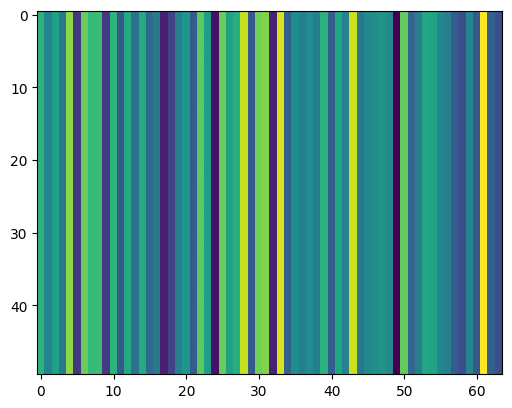

In [17]:
model.eval()
results = []
origin = []
embeddings = []

properties_results=[]
properties_origin=[]
print(len(val_dataset))
with torch.no_grad():
    for (smiles_enc, smiles_dec_input, smiles_dec_output, properties, label) in val_dataloader:

        smiles_enc = smiles_enc.to(device)
        smiles_dec_input = smiles_dec_input.to(device)
        smiles_dec_output = smiles_dec_output.to(device)
        properties = properties.to(device)

        logits, mu_q, logvar_q, pi_p, mu_p, logvar_p, z_q, prop_pred, encoded, _, _ = model(smiles_enc, smiles_dec_input, properties)

        # mask = build_grammar_mask_batch(smiles_dec_input, {idx: token for token, idx in dataset.vocab.items()}, dataset.vocab_size, 2, 166).to(device)
        # logits = logits.masked_fill(~mask, float('-1e3'))

        results.append(logits)
        origin.append(smiles_dec_output)

        properties_results.append(prop_pred)
        properties_origin.append(properties)
        embeddings.append(mu_q)

results = torch.cat(results, dim=0)
origin = torch.cat(origin, dim=0)
results = F.softmax(results, dim=-1) 
argmax_indices = torch.argmax(results, dim=-1)
output = F.one_hot(argmax_indices, num_classes=results.size(-1))

print(results.shape)
print(origin.shape)

from sklearn.metrics import mean_absolute_error
properties_origin=torch.cat(properties_origin,dim=0)
properties_results=torch.cat(properties_results,dim=0)
results_smiles = []
origin_smiles = []
for i in range(results.shape[0]):
    results_smiles.append(atomInSmiles.decode(' '.join(reverse_one_hot_encoding(results[i], dataset.vocab))))
    origin_smiles.append(atomInSmiles.decode(' '.join(reverse_one_hot_encoding(origin[i], dataset.vocab))))



randoms = np.random.randint(low=0,high=1566,size=50)
randoms = np.array((randoms//256, randoms%256))

stack = torch.stack([embeddings[randoms[0, i]][randoms[1, i]].unsqueeze(0) for i in range(randoms.shape[1])], axis=0).squeeze()
stack = stack[:,0,:].detach().cpu().numpy()

print(stack.shape)
plt.figure(figsize=(6, 5))
plt.imshow(stack)




In [18]:


# origin_smiles = [smiles.removesuffix("EOS").strip() for smiles in origin_smiles]
# results_smiles = [smiles.removesuffix("EOS").strip() for smiles in results_smiles]


for i in range(len(results_smiles)):
    if(origin_smiles[i] != results_smiles[i]):
        print(i, "번째 다름!")
    print("real smiles      : ", origin_smiles[i])
    print("predicted smiles : ", results_smiles[i])


MAE = mean_absolute_error(origin.cpu(), torch.argmax(results.cpu(), dim=-1))
print("MAE : ", MAE)



0 번째 다름!
real smiles      :  *OCC(C)N(CCC)CC(C)OC(*)=O
predicted smiles :  *OCCNC)NCCCC)CCOC)OC)*)=O
1 번째 다름!
real smiles      :  *OC(CC)C(NC(*)=O)C(=O)OCC
predicted smiles :  *OCCCC)CNCC**)=O)CO=O)OCC
2 번째 다름!
real smiles      :  *OCC(C)NC(=O)C(C)C(CC)OC(*)=O
predicted smiles :  *OCCNC)NCC=O)CCC)C)CC)OC
3 번째 다름!
real smiles      :  *NCCCCC(=O)NCC(CC)NC(*)=O
predicted smiles :  *NCCCCCN=O)NCCNCC)NC**)=O
4 번째 다름!
real smiles      :  *OCC(NC(*)=O)C(=O)NCCCC
predicted smiles :  *OCCNCC**)=O)CS=O)NCCCC
5 번째 다름!
real smiles      :  *OCC(=O)NCC(COC(*)=O)C(C)C
predicted smiles :  *OCCN=O)NCCCCOC)*)=O)CCC)C
6 번째 다름!
real smiles      :  *OC(C=O)C(O)=C(O)COC(*)=O
predicted smiles :  *OCCC=O)C=O)CC)O)=OC)*)=O
7 번째 다름!
real smiles      :  *OCC(C=C)NC(=O)CCCCOC(*)=O
predicted smiles :  *OCCNC=C)NCC=O)CCCCOC
8 번째 다름!
real smiles      :  *NCCCN(C)CC(CSC)OC(*)=O
predicted smiles :  *NCCCNCC)CCOCSC)OC)*)=O
9 번째 다름!
real smiles      :  *NCC(COC(C)(C)C)OC(*)=O
predicted smiles :  *NCCOCOCCC)CC)O)OC)*)=O


In [16]:
from rdkit import Chem, RDLogger
from rdkit.Chem import DataStructs, rdFingerprintGenerator
RDLogger.DisableLog('rdApp.error')

generator = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
def tanimoto_similarity(smiles1, smiles2):
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    fp1 = generator.GetFingerprint(mol1)
    fp2 = generator.GetFingerprint(mol2)
    return DataStructs.TanimotoSimilarity(fp1, fp2)

def is_valid(smiles):
    return Chem.MolFromSmiles(smiles) is not None



TS = 0
canbe = 0
notbe = 0


for i in range(len(results_smiles)):
    predicted=results_smiles[i].replace("(*)","")
    predicted = predicted.replace("*", "")

    origin = origin_smiles[i].replace("(*)", "")
    origin = origin.replace("*", "")

    if is_valid(predicted) and is_valid(origin):
        raw = tanimoto_similarity(predicted, origin)
        canbe += 1
    else:
        notbe += 1
    TS += raw
PS.fingerprint
print("Tanimoto Similarity : ", TS / canbe)
print("가능한 분자 개수 : ", canbe)
print("불가능한 분자 개수 :", notbe)
print(canbe / len(results_smiles))

NameError: name 'raw' is not defined

In [ ]:
for name, param in model.named_parameters():
    print(f"Layer: {name}, shape: {param.shape}")

state = model.state_dict()

# state 딕셔너리의 키 확인 (해당 키 이름은 named_parameters()와 동일)
print(state.keys())


In [ ]:
save_path = "model_weights_dmodel256.pth"
torch.save(model.state_dict(), save_path)
save_path = "model_weights_prior.pth"


In [ ]:
save_path = "model_weights_dmodel256.pth"
state_dict = torch.load(save_path)
model.load_state_dict(state_dict)



<All keys matched successfully>

In [19]:
tn_data = load_data("simulation-trajectory-aggregate_aligned.csv")

tn = DataLoader(tn_data, batch_size=256, shuffle=False, drop_last=False)



max sequence length :  265
{'(': 0, ')': 1, '=': 2, '[O;!R;C]': 3, '[CH3;!R;C]': 4, '[CH2;!R;CN]': 5, '[CH2;!R;CC]': 6, '[CH2;!R;CO]': 7, '[*;!R;C]': 8, '[CLS]': 9, '[SOS]': 10, '[EOS]': 11, '[O;!R;CC]': 12, '[NH;!R;CC]': 13, '[*;!R;O]': 14, '[O;!R;*C]': 15, '[C;!R;*OO]': 16, '[CH;!R;CCO]': 17, '[CH;!R;CCN]': 18, '[C;!R;CNO]': 19, '[N;!R;CCC]': 20, '[C;!R;*NO]': 21, '[NH;!R;*C]': 22, '[*;!R;N]': 23, '[CH3;!R;N]': 24, '[CH;!R;CCC]': 25, '[C;!R;CCCO]': 26, '[CH;!R;CC]': 27, '[F;!R;C]': 28, '[CH2;!R;C]': 29, '[C;!R;COO]': 30, '[CH3;!R;O]': 31, '[C;!R;CCCN]': 32, '#': 33, '[C;!R;CCCC]': 34, '[CH2;!R;CS]': 35, '[C;!R;CC]': 36, '[OH;!R;C]': 37, '[S;!R;CC]': 38, '[N;!R;C]': 39, '[C;!R;CN]': 40, '[CH;!R;C]': 41, '[C;!R;CCC]': 42, '[NH2;!R;C]': 43, '[CH;!R;CFF]': 44, '[O;!R;S]': 45, '[O;!R;CN]': 46, '[CH;!R;CCS]': 47, '[CH2;!R;CF]': 48, '[CH3;!R;S]': 49, '[C;!R;CCO]': 50, '[NH;!R;CO]': 51, '[CH2;!R;*C]': 52, '[C;!R;NNO]': 53, '[C;!R;CFFF]': 54, '[C;!R;CCFF]': 55, '[C;!R;NOO]': 56, '[C;!R;OOO]':

In [20]:
model.eval()
results = []
origin = []
z_tn = []
mean_tn = []
log_var_tn = []
mu_p_tn=[]
var_p_tn=[]
pi_p_tn=[]
labels=[]
with torch.no_grad():
    for (smiles_enc, smiles_dec_input, smiles_dec_output, properties, label) in tn:

        smiles_enc = smiles_enc.to(device)
        smiles_dec_input = smiles_dec_input.to(device)
        smiles_dec_output = smiles_dec_output.to(device)
        properties = properties.to(device)

        logits, mu_q, logvar_q, pi_p, mu_p, logvar_p, z_q, prop_pred, encoded, _,_ = model(smiles_enc, smiles_dec_input, properties)

        mean_tn.append(mu_q)
        log_var_tn.append(logvar_q)
        z_tn.append(z_q)
        mu_p_tn.append(mu_p)
        var_p_tn.append(logvar_p)
        pi_p_tn.append(pi_p)
        labels.append(label)

In [21]:
z_tn = torch.cat(z_tn, dim=0)
mean_tn = torch.cat(mean_tn, dim=0)
log_var_tn = torch.cat(log_var_tn, dim=0)
mu_p_tn = torch.cat(mu_p_tn, dim=0)
var_p_tn = torch.cat(var_p_tn, dim=0)
pi_p_tn = torch.cat(pi_p_tn, dim=0)
labels = torch.cat(labels, dim=0)

In [22]:
print(z_tn.shape)
print(mean_tn.shape)
print(log_var_tn.shape)
print("sigma mean :", log_var_tn.mean().item())
print("sigma std :", log_var_tn.std().item())



torch.Size([6270, 265, 64])
torch.Size([6270, 265, 64])
torch.Size([6270, 265, 64])
sigma mean : 0.04033338651061058
sigma std : 0.04051746428012848


In [23]:
def split_data(matrix, list):
    splited=[]
    max_len = matrix.shape[0]
    for i in range(len(list)):
        if i==0:
            splited.append(matrix[:list[i]])
        elif i == len(list)-1:
            splited.append(matrix[list[i-1]:list[i]])
            splited.append(matrix[list[i]:])
        else:
            splited.append(matrix[list[i-1]:list[i]])
    return splited

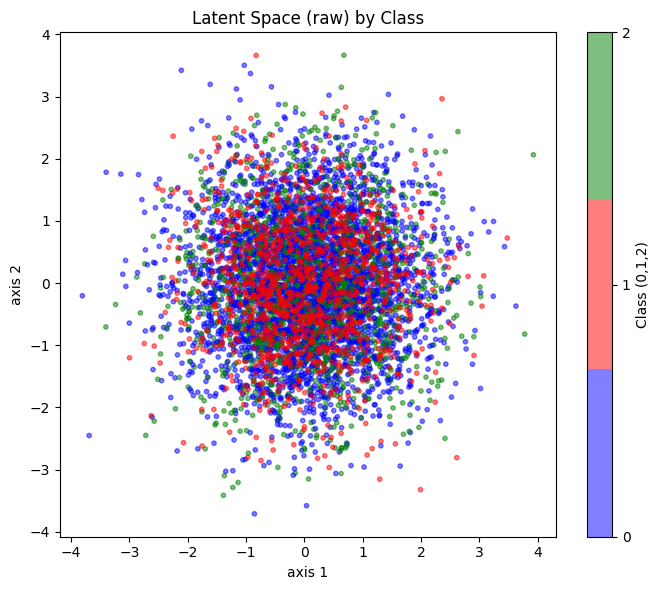

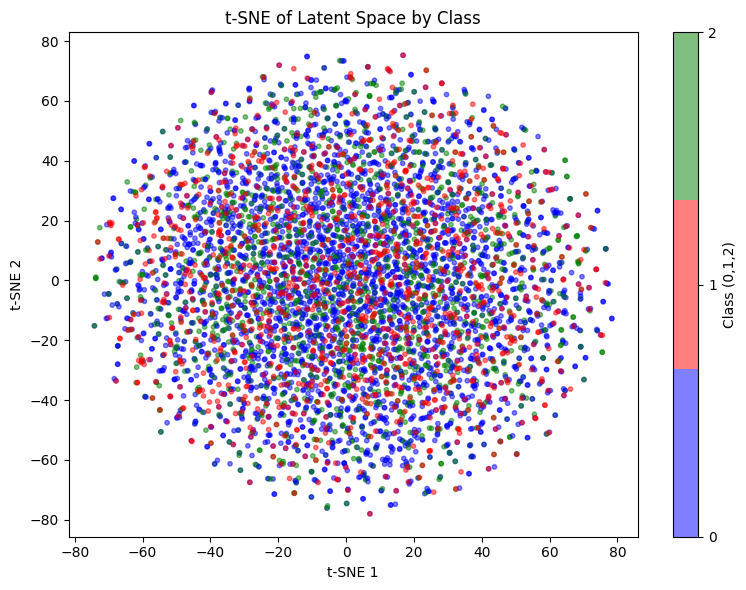

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
from umap.umap_ import UMAP
from sklearn.decomposition import PCA
# 1) TSNE 등 준비
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
umap = UMAP(n_components=2, n_neighbors=15)
pca = PCA(n_components=2)
prior_z = model.reparameterize(mu_p_tn, var_p_tn)
X = z_tn[:,0,:].squeeze().detach().cpu().numpy()   # (N, D)
reduced = tsne.fit_transform(X)                    # (N, 2)
#reduced = umap.fit_transform(X)
#reduced = pca.fit_transform(X)
# 2) float label → 0,1,2 int로 매핑
raw_labels = labels.squeeze().detach().cpu().numpy()  # (N,)
label_values = [0.0, 1.0, 2.0]  # 대응하고 싶은 float 값들
def match_label(v, label_list, tol=1e-3):
    for i, val in enumerate(label_list):
        if np.isclose(v, val, atol=tol):
            return i
    return -1

int_labels_full = np.array([match_label(v, label_values) for v in raw_labels])  # (N,)

# 3) 한 번의 마스크로 모두 필터링
mask = int_labels_full != -1
X_valid       = X[mask]
reduced_valid = reduced[mask]
int_labels    = int_labels_full[mask]

# 4) 컬러맵 준비 (3개 색)
colors = ['blue','red','green']
cmap   = ListedColormap(colors)

# — raw latent 공간 시각화 —
plt.figure(figsize=(7,6))
sc = plt.scatter(
    X_valid[:,0], X_valid[:,1],
    c=int_labels, cmap=cmap,
    s=10, alpha=0.5,
    vmin=0, vmax=2
)
cbar = plt.colorbar(sc, ticks=[0,1,2])
cbar.set_label("Class (0,1,2)")
plt.title("Latent Space (raw) by Class")
plt.xlabel("axis 1")
plt.ylabel("axis 2")
plt.tight_layout()
plt.show()

# — t-SNE 시각화 —
plt.figure(figsize=(8,6))
sc2 = plt.scatter(
    reduced_valid[:,0], reduced_valid[:,1],
    c=int_labels, cmap=cmap,
    s=10, alpha=0.5,
    vmin=0, vmax=2
)
cbar2 = plt.colorbar(sc2, ticks=[0,1,2])
cbar2.set_label("Class (0,1,2)")
plt.title("t-SNE of Latent Space by Class")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()


In [ ]:
%matplotlib
from mpl_toolkits.mplot3d import Axes3D
print(reduced.shape)
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reduced[:113, 0], reduced[:113, 1], reduced[:113, 2], color='orange')
ax.scatter(reduced[113:1942, 0], reduced[113:1942, 1], reduced[113:1942, 2], color='green')
ax.scatter(reduced[1942:4151, 0], reduced[1942:4151, 1], reduced[1942:4151, 2], color='red')
ax.scatter(reduced[4151:, 0], reduced[4151:, 1], reduced[4151:, 2], color='blue')

In [ ]:
dd = reverse_one_hot_encoding(torch.tensor(generated_tokens), dataset.vocab)
del dd[0]
del dd[-1]
print(dd)

ddd = atomInSmiles.decode(' '.join(dd))
print(ddd)
PS(ddd)

In [ ]:
import sascorer
m = Chem.MolFromSmiles("COCC(NC(C)=O)C(=O)NC(C)CC#N")

print(sascorer.calculateScore(m))

m = Chem.MolFromSmiles("OC(CNCCCCCCCC)COC=O")

sascorer.calculateScore(m)